In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
import os
import sys
import json
import requests
from tqdm import tqdm
import utils

import deepchem as dc
from rdkit.Chem import AllChem, Lipinski, Descriptors, Crippen
from rdkit import Chem, DataStructs
import torch
from sklearn.metrics.pairwise import cosine_similarity
import gseapy as gp
import models.moable.model

import pandas as pd
import numpy as np
import pickle
import faiss

from upsetplot import plot, from_contents, UpSet
from sklearn.manifold import TSNE
import umap
import plotly.io as po
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from IPython.display import HTML, display, Markdown, IFrame, FileLink, Image, HTML

sys_path = "/home/songhyeon/Research/Embedding_appyter"
sys.path.append(sys_path)

/home/songhyeon/anaconda3/envs/Embdd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/songhyeon/anaconda3/envs/Embdd/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
%%appyter hide_code
{% do SectionField(
    name='LB_Section',
    title='Select a Library',
    subtitle='Option 1: Select your library: KCB(Korean Chemical Bank, 600K), ZINC(20K), MCE(1K), Selleckchem(2K). 
    Option 2: Upload your custom library.',
    img='library.png'
) %}

%%appyter hide_code
{% do SectionField(
    name='Data_Section',
    title='Load your Data',
    subtitle='Load your data in tab separated formats without headers and index columns (One drug per row). 
    Option 1: One query compound. 
    Option 2: Multiple query compounds (maximum 10 compounds).',
    img='data.png'
) %}

%%appyter hide_code
{% do SectionField(
    name='Parameter_Section',
    title='Set Parameters',
    subtitle='You can set various parameters. 
    Option 1: the maximum number(K) of top candidates.
    Option 2: Choose gene expression-based, fingerprint-based, sequence-based, or graph-based embedding methods.
    Option 3: Choose similarity search methods. Default method is "Cosine similarity".
    Option 4: Set the similarity score threshold. Dafault threshold is 0.9.',
    img='setting.png'
) %}

```python
%%appyter hide_code
%%appyter hide_code
```

In [4]:
%%appyter hide_code_exec

{% set LB_field = TabField(
    name='lb_field',
    label='Library Selection',
    default='Select a Library',
    choices={
        'Select a Library': [
            ChoiceField(
                name='lb_kind',
                label='Select your library',
                default='Selleckchem',
                choices={'KCB':'kcb','ZINC':'zinc','MCE':'mce','Selleckchem':'selleck'}
            )
        ],
        'Custom Library': [
            FileField(
                name='custom',
                label='Load your Custom Library',
                description='Tab-delimeted file of your library. Columns should correspond to Drug2 Name, Drug2 SMILES without any headers and index columns'),
            StringField(
                name='custom_info', 
                label='Custom Information', 
                default='', 
                description='Columns name of information you want to highlight in the custom library.'
            )
        ]
    },
    section = 'LB_Section')
 %}

In [5]:
%%appyter hide_code_exec
{% set input_types = TabField(
    name='input_types',
    label='Data file',
    default='Multiple Query Compounds',
    description='Upload your drugs information files',
    choices={        
        'One Query Compound': [
            StringField(
                name='drug1_name', 
                label='Query Drug Name', 
                default='Palbociclib', 
                description='', 
                section='Data_Section'
            ),
            StringField(
                name='drug1_smiles', 
                label='Query Drug SMILES', 
                default='CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N3CCNCC3)N=C2N(C2CCCC2)C1=O', 
                description='', 
                section='Data_Section'
            )
        ],
        'Multiple Query Compounds':[
            FileField(
                name='drug1_list_filename', 
                label='List of Candidates (.tsv or .txt)', 
                default='/home/songhyeon/Research/Embedding_appyter/drugs.txt',
                description='List of Candidates. Columns should correspond to Drug 1 Name and Drug 1 SMILES. One drug per row',
                section='Data_Section'
            )]

    },
    section = 'Data_Section',
) %}

In [6]:
%%appyter hide_code_exec
{% set topk_candidate = IntField(
    name='topk_candidate', 
    label='Top K Candidates', 
    min=1, 
    max=10000, 
    default=30, 
    description='The maximum number of Top candidates', 
    section='Parameter_Section')
%}

{% set embedding_method = ChoiceField(
    name='embedding_method',
    label='Embedding Methods',
    choices={'ReSimNet (Expression-based)':'resimnet','MoAble (Expression-based)':'moable','ECFP (Fingerprint-based)':'ecfp','MACCS Keys (Fingerprint-based)':'maccskeys',
             'Mol2vec (Sequence-based)':'mol2vec'},
    default='ReSimNet (Expression-based)',
    description='Select a embedding method',
    section='Parameter_Section')
%}

{% set similarity_method = ChoiceField(
    name='similarity_method',
    label='Similarity Methods',
    choices={'Cosine similarity':'cosine', 'Euclidean similarity':'euclidean'},
    default='Euclidean similarity',
    description='Select a similarity method to calculate',
    section='Parameter_Section')
%}

In [7]:
%%appyter code_exec

input_path = 'input_data/'
if not os.path.exists(input_path):
    os.makedirs(input_path)
    
output_path = 'output_data/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

```python
input_path = 'input_data/'
if not os.path.exists(input_path):
    os.makedirs(input_path)
output_path = 'output_data/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
```

In [8]:
%%appyter code_exec

# database_field
{% if LB_field.raw_value == "Select a Library" %}
input_db = "{{ LB_field.value[0] }}"

{% elif LB_field.raw_value == "Custom Library" %}
input_db = "custom"
input_db_df = pd.read_csv({{ LB_field.value[0] }}, sep='\t', usecols=['drug2_name', 'drug2_smiles'])
{% endif %}

# prototypes_field
{% if input_types.raw_value == "One Query Compound" %}
drug1_name = {{ input_types.value[0] }}
drug1_smiles = {{ input_types.value[1] }}
input_mode = "single"

{% elif input_types.raw_value == "Multiple Query Compounds" %}
query_filename = {{ input_types.value[0] }}
input_mode = "multiple"
{% endif %}

# set parameters
embed_method = "{{embedding_method.value}}"
sim_method = "{{similarity_method.value}}"
topk_candidate = {{topk_candidate.value}}
library_df = utils.library_npl(input_db)[0]
npl = utils.library_npl(input_db)[1]

```python
# database_field
input_db = "selleck"
# prototypes_field
query_filename = '/home/songhyeon/Research/Embedding_appyter/drugs.txt'
input_mode = "multiple"
# set parameters
embed_method = "resimnet"
sim_method = "euclidean"
topk_candidate = 100
library_df = utils.library_npl(input_db)[0]
npl = utils.library_npl(input_db)[1]
```

## Generating embedding vector

In [9]:
if input_mode == 'multiple':
    df = pd.read_csv(query_filename, sep="\t", header=None)
    df.columns = ["drug1_name", "drug1_smiles"]
    drug_dict = dict(zip(df["drug1_name"], df["drug1_smiles"]))
    filenames = []
    combined = []
    embed_dict = {}
    output_file = f'{embed_method}_embedding_vectors.pkl'

# Gene expression
    if embed_method == 'resimnet':
        for name, smiles in drug_dict.items():
            globals()[f'input_embed_{name}'] = {name:smiles}
            with open(input_path + f'input_{name}.pkl', "wb") as f:
                pickle.dump(globals()[f'input_embed_{name}'], f)
                            
            input_embed_filename = input_path + f"input_{name}.pkl"
            output_embed_filename = output_path + f"output_{name}_embeddings.pkl"
            resimnet_model_filename = "ReSimNet7.mdl"
            filenames.append(output_embed_filename)
            
            !python $sys_path/models/ReSimNet/main.py --save-embed True --embed-d 2 --drug-file $input_embed_filename --output-filename $output_embed_filename --checkpoint-dir $sys_path/models/ReSimNet/results/ --model-name $resimnet_model_filename --data-path $sys_path/models/ReSimNet/tasks/data/drug\(v0.6\).pkl
            
        for file in filenames:
            with open(file, 'rb') as file:
                data = pickle.load(file)
                combined.append(data)
        
        with open(output_path+output_file, 'wb') as file:
            pickle.dump(combined, file) 

    elif embed_method == 'moable':
        embed_dict = utils.drug_embeddings(drug_dict)
        with open(output_path + output_file,'wb') as f:
            pickle.dump(embed_dict, f)
        for k, v in embed_dict.items():
            with open(output_path + f'{k}_output_embedding.pkl', 'wb') as f:
                pickle.dump({k:v}, f)
            
# Sequence
    elif embed_method == 'mol2vec':
        featurizer = dc.feat.Mol2VecFingerprint('/home/songhyeon/Research/Embedding_appyter/models/mol2vec/mol2vec_model_300dim.pkl')
        for name, smiles in drug_dict.items():
            with open(output_path + f'{name}_output_embedding.pkl', 'wb') as f:
                pickle.dump({name: featurizer.featurize(smiles)}, f)
            with open(output_path + output_file, 'wb') as f:
                globals()[f'input_{name}'] = {name: featurizer.featurize(smiles)}
                embed_dict.update(globals()[f'input_{name}'])
                pickle.dump(embed_dict, f)
        
# Fingerprint
    elif embed_method == 'ecfp':
        for name, smiles in drug_dict.items():
            with open(output_path + f'{name}_output_embedding.pkl', 'wb') as f:
                pickle.dump({name:utils.smiles2fp(smiles)}, f)
            with open(output_path + output_file, 'wb') as f:
                globals()[f'input_{name}'] = {name:utils.smiles2fp(smiles)}
                embed_dict.update({name:utils.smiles2fp(smiles)})
                pickle.dump(embed_dict, f)


    elif embed_method == 'maccskeys':
        featurizer = dc.feat.MACCSKeysFingerprint()
        for name, smiles in drug_dict.items():
            with open(output_path + f'{name}_output_embedding.pkl', 'wb') as f:
                pickle.dump({name:featurizer.featurize(smiles)}, f)
            with open(output_path + output_file, 'wb') as f:
                globals()[f'input_{name}'] = {name:featurizer.featurize(smiles)}
                embed_dict.update(globals()[f'input_{name}'])
                pickle.dump(embed_dict, f)

    embedding_html = "<a href=\"./{}\" target='_blank'>{}</a>".format(output_path+output_file, f"Download {embed_method} embedding vectors")
    display(HTML(embedding_html))

/home/songhyeon/anaconda3/envs/Embdd/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/songhyeon/anaconda3/envs/Embdd/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# result_df
for name in drug_dict.keys():
    if embed_method == 'resimnet':
        globals()[f'{name}_simliarity'], globals()[f'{name}_index'], globals()[f'{name}_result_df'] = utils.resimnet_finder(input_db, npl, output_path+f'output_{name}_embeddings.pkl', topk_candidate, name, "ReSimNet7")
        
        globals()[f'{name}_result_df'] = pd.concat(globals()[f'{name}_result_df'], axis=1).reset_index()
        globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].rename(columns={"index":"drug2_name"})
        globals()[f'{name}_result_df'] = pd.merge(globals()[f'{name}_result_df'], library_df)
        
        globals()[f'{name}_df'] =  globals()[f'{name}_result_df']
        globals()[f'{name}_df']["drug1_name"] = name
        globals()[f'{name}_df']["drug1_smiles"] = smiles

        input_filename = f"./input_pairs_{name}.tsv"
        output_filename = f"output_data/output_pairs_{name}.tsv"
        globals()[f'{name}_df'].to_csv(input_filename, index=None, sep="\t")

        # resimnet score calculation
        !python $sys_path/models/ReSimNet/main.py --save-prediction-new-pairs True --new-drug-pair-filename $input_filename --output-filename $output_filename --checkpoint-dir $sys_path/models/ReSimNet/results/ --data-path $sys_path/models/ReSimNet/tasks/data/drug\(v0.6\).pkl
        
    else:
        data_filename = f"{name}_candidates.tsv"      
        if embed_method == 'mol2vec':
            globals()[f'{name}_simliarity'], globals()[f'{name}_index'], globals()[f'{name}_result_df'] = utils.finder(input_db, embed_method, npl, sim_method, output_path+f'{name}_output_embedding.pkl', topk_candidate, name)

        elif embed_method == 'ecfp':
            globals()[f'{name}_simliarity'], globals()[f'{name}_index'], globals()[f'{name}_result_df'] = utils.finder(input_db, embed_method, npl, sim_method, output_path+f'{name}_output_embedding.pkl', topk_candidate, name)
        
        elif embed_method == 'maccskeys':
            globals()[f'{name}_simliarity'], globals()[f'{name}_index'], globals()[f'{name}_result_df'] = utils.finder(input_db, embed_method, npl, sim_method, output_path+f'{name}_output_embedding.pkl', topk_candidate, name)
        
        elif embed_method == 'moable':
            globals()[f'{name}_simliarity'], globals()[f'{name}_index'], globals()[f'{name}_result_df'] = utils.finder(input_db, embed_method, npl, sim_method, output_path+f'{name}_output_embedding.pkl', topk_candidate, name)

        globals()[f'{name}_result_df'] = pd.concat(globals()[f'{name}_result_df'], axis=1).reset_index()
        globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].rename(columns={"index":"drug2_name"})
        globals()[f'{name}_result_df'] = pd.merge(globals()[f'{name}_result_df'], library_df)
        globals()[f'{name}_result_df'][f'{sim_method} similarity'] = globals()[f'{name}_simliarity'][0]
        globals()[f'{name}_result_df']['rank'] = [x for x in range(1,topk_candidate+1)]
        globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].set_index(['rank'])
        globals()[f'{name}_result_df']['drug2_smiles'] = globals()[f'{name}_result_df'].apply(lambda x: utils.make_clickable(x['drug2_smiles']), axis=1)
        globals()[f'{name}_result_df'].rename(columns={'drug2_name':'compound_name', 'drug2_smiles':'compound_smiles'}, inplace=True)

        globals()[f'{name}_result_df'].to_csv(data_filename, sep='\t')

100%|██████████| 10/10 [00:00<00:00, 102.56it/s]


seliciclib: Searching from 3729 candidates...
/home/songhyeon/anaconda3/envs/Embdd/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


100%|██████████| 10/10 [00:00<00:00, 107.13it/s]


Palbociclib: Searching from 3729 candidates...
/home/songhyeon/anaconda3/envs/Embdd/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


100%|██████████| 10/10 [00:00<00:00, 106.79it/s]


indisulam: Searching from 3729 candidates...
/home/songhyeon/anaconda3/envs/Embdd/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


100%|██████████| 10/10 [00:00<00:00, 105.24it/s]


Meloxicam: Searching from 3729 candidates...
/home/songhyeon/anaconda3/envs/Embdd/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
if embed_method == 'resimnet':
    for name, smiles in drug_dict.items():
        output_filename = output_path + f'output_pairs_{name}.tsv'
        globals()[f'{name}_result_df'] = pd.read_csv(output_filename, sep="\t")
        globals()[f'{name}_result_df']['drug2_smiles'] = globals()[f'{name}_result_df'].apply(lambda x: utils.make_clickable(x['drug2_smiles']), axis=1)
        globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].set_index(['drug2_name', 'drug2_smiles'])
        globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].drop(['drug1_name','drug1_smiles'], axis=1)
        globals()[f'{name}_result_df']["ReSimNet_avg"] = globals()[f'{name}_result_df'][[x for x in globals()[f'{name}_result_df'].columns if x.startswith("ReSimNet")]].mean(axis=1)
        globals()[f'{name}_result_df']['ReSimNet_std'] = globals()[f'{name}_result_df'][[x for x in globals()[f'{name}_result_df'].columns if x.startswith('ReSimNet')]].std(axis=1)
        # order columns
        globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].reindex(sorted(globals()[f'{name}_result_df'].columns), axis=1)
        globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].sort_values(["ReSimNet_avg", "jaccard_similarity"], ascending=False)
        globals()[f'{name}_result_df'].reset_index(drop=False, inplace=True)
        # rank
        globals()[f'{name}_result_df']['rank'] = [x for x in range(1,topk_candidate+1)]
        globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].set_index(['rank'])
        
        # html
        globals()[f'{name}_result_df1'] = pd.read_csv(output_filename, sep="\t")
        globals()[f'{name}_result_df1']['drug2_smiles'] = globals()[f'{name}_result_df1'].apply(lambda x: utils.make_clickable(x['drug2_smiles']), axis=1)
        globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df1'].set_index(['drug2_name', 'drug2_smiles'])
        globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df1'].drop(['drug1_name','drug1_smiles'], axis=1)
        globals()[f'{name}_result_df1']["ReSimNet_avg"] = globals()[f'{name}_result_df1'][[x for x in globals()[f'{name}_result_df1'].columns if x.startswith("ReSimNet")]].mean(axis=1)
        globals()[f'{name}_result_df1']['ReSimNet_std'] = globals()[f'{name}_result_df1'][[x for x in globals()[f'{name}_result_df1'].columns if x.startswith('ReSimNet')]].std(axis=1)
        # order columns
        globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df1'].reindex(sorted(globals()[f'{name}_result_df1'].columns), axis=1)
        globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df1'].sort_values(["ReSimNet_avg", "jaccard_similarity"], ascending=False)
        globals()[f'{name}_result_df1'].reset_index(drop=False, inplace=True)
        # rank
        globals()[f'{name}_result_df1']['rank'] = [x for x in range(1,topk_candidate+1)]
        globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df1'].set_index(['rank'])
        globals()[f'{name}_result_df1'].drop(columns=['ReSimNet_0','ReSimNet_1','ReSimNet_2','ReSimNet_3','ReSimNet_4','ReSimNet_5','ReSimNet_6','ReSimNet_7','ReSimNet_8','ReSimNet_9'], inplace=True)
        globals()[f'{name}_result_df1'].rename(columns={'drug2_name':'compound_name', 'drug2_smiles':'compound_smiles'}, inplace=True)

In [26]:
css = """
<style>
table.dataframe td{
    white-space: pre-wrap;
    max-width: 450px;
    overflow: hidden;
}
</style>
"""
i = 1
styles = [dict(selector="caption", props=[("text-align", "left")])]
for name in drug_dict.keys():
    if embed_method == 'resimnet':
        globals()[f'{name}_result_df2'] = globals()[f'{name}_result_df1'].style.set_caption(f"Table {i}. Top {topk_candidate} compounds similar to {name} based on {embed_method} embedding").set_table_styles(styles)
        globals()[f'{name}_result_df'].to_csv(f'{name}_results.tsv',sep='\t')
        i += 1
        globals()[f'{name}_html'] = "<a href=\"./{}\" target='_blank'>{}</a>".format(f'{name}_results.tsv', "Download results: {}".format(f'{name}_results.tsv'))
        display(HTML(css + globals()[f'{name}_result_df2'].to_html(render_links=True, escape=False)))
        display(HTML(globals()[f'{name}_html']))
        
    else:
        globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df'].style.set_caption(f"Table {i}. Top {topk_candidate} compounds similar to {name} based on {embed_method} embedding").set_table_styles(styles)
        globals()[f'{name}_result_df'].to_csv(f'{name}_results.tsv',sep='\t')
        i += 1
        globals()[f'{name}_html'] = "<a href=\"./{}\" target='_blank'>{}</a>".format(f'{name}_results.tsv', "Download results: {}".format(f'{name}_results.tsv'))
        display(HTML(css + globals()[f'{name}_result_df1'].to_html(render_links=True, escape=False)))
        display(HTML(globals()[f'{name}_html']))

,compound_name,compound_smiles,ReSimNet_avg,ReSimNet_std,jaccard_similarity
rank,,,,,
1,"79-6 (CID5721353, BCL6 inhibitor)",OC(=O)CC(N1C(=S)S/C(C1=O)=C/2C(=O)NC3=CC=C(Br)C=C23)C(O)=O,0.873646,0.039117,0.103448
2,NVP-ADW742,NC1=NC=NC2=C1C(=C[N]2C3CC(C3)CN4CCCC4)C5=CC(=CC=C5)OCC6=CC=CC=C6,0.850182,0.037176,0.092784
3,KRIBB11,CNC1=CC=C(C(=N1)NC2=CC=C3[NH]N=CC3=C2)[N+]([O-])=O,0.848887,0.042687,0.125000
4,OSI-930,FC(F)(F)OC1=CC=C(NC(=O)C2=C(NCC3=CC=NC4=CC=CC=C34)C=CS2)C=C1,0.844481,0.069734,0.160920
5,Vadadustat,OC(=O)CNC(=O)C1=NC=C(C=C1O)C2=CC=CC(=C2)Cl,0.843874,0.042342,0.175676
6,5-Bromoindole,BrC1=CC2=C([NH]C=C2)C=C1,0.842354,0.025158,0.046875
7,Pexmetinib (ARRY-614),CC1=CC=C(C=C1)[N]2N=C(C=C2NC(=O)NCC3=C(OC4=CC5=C(C=C4)[N](CCO)N=C5)C=CC(=C3)F)C(C)(C)C,0.837848,0.083008,0.133333
8,BI-78D3,OC1=NN=C(SC2=NC=C(S2)[N+]([O-])=O)[N]1C3=CC=C4OCCOC4=C3,0.833369,0.040125,0.139535
9,Branaplam (LMI070),CC1(C)CC(CC(C)(C)N1)OC2=NN=C(C=C2)C3=C(O)C=C(C=C3)C4=C[NH]N=C4,0.829868,0.037370,0.119048


,compound_name,compound_smiles,ReSimNet_avg,ReSimNet_std,jaccard_similarity
rank,,,,,
1,Meloxicam,CN1C(=C(O)C2=C(C=CC=C2)[S]1(=O)=O)C(=O)NC3=NC=C(C)S3,1.000000,0.000000,1.000000
2,Palbociclib (PD0332991) Isethionate,CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2N(C5CCCC5)C1=O.OCC[S](O)(=O)=O,0.924475,0.033519,0.122642
3,Palbociclib (PD-0332991) HCl,Cl.CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2N(C5CCCC5)C1=O,0.923698,0.031622,0.135417
4,LY2584702 Tosylate,C[N]1C=C(N=C1C2CCN(CC2)C3=NC=NC4=C3C=N[NH]4)C5=CC(=C(F)C=C5)C(F)(F)F.CC6=CC=C(C=C6)[S](O)(=O)=O,0.910074,0.029124,0.142857
5,Torkinib (PP242),CC(C)[N]1N=C(C2=CC3=C([NH]2)C=CC(=C3)O)C4=C(N)N=CN=C14,0.909307,0.023983,0.120482
6,Erlotinib,COCCOC1=C(OCCOC)C=C2C(=NC=NC2=C1)NC3=CC=CC(=C3)C#C,0.906052,0.041622,0.107143
7,LY2608204,O=C(NC1=NC=C(SCCN2CCCC2)S1)C3(CC3C4CCCCC4)C5=CC=C(C=C5)[S](=O)(=O)C6CC6,0.905412,0.039544,0.191489
8,Erlotinib HCl (OSI-744),Cl.COCCOC1=C(OCCOC)C=C2C(=NC=NC2=C1)NC3=CC=CC(=C3)C#C,0.904359,0.041601,0.105882
9,JQ-EZ-05 (JQEZ5),CCCC1=C(CNC(=O)C2=CC(=NC3=C2C=N[N]3C(C)C)C4=CC=C(N=C4)N5CCN(C)CC5)C(=O)NC(=C1)C,0.902855,0.034274,0.153846


,compound_name,compound_smiles,ReSimNet_avg,ReSimNet_std,jaccard_similarity
rank,,,,,
1,WM-8014,CC1=CC(=CC(=C1F)C(=O)NN[S](=O)(=O)C2=CC=CC=C2)C3=CC=CC=C3,0.887023,0.036349,0.162162
2,Pilocarpine HCl,Cl.CCC1C(COC1=O)CC2=CN=C[N]2C,0.886257,0.025564,0.121622
3,Hydroxyzine pamoate,OCCOCCN1CCN(CC1)C(C2=CC=CC=C2)C3=CC=C(Cl)C=C3.OC(=O)C4=C(O)C(=C5C=CC=CC5=C4)CC6=C7C=CC=CC7=CC(=C6O)C(O)=O,0.874390,0.048399,0.114583
4,RSL3,COC(=O)C1CC2=C([NH]C3=C2C=CC=C3)C(N1C(=O)CCl)C4=CC=C(C=C4)C(=O)OC,0.867488,0.036908,0.134831
5,Magnolin,COC1=C(OC)C=C(C=C1)C2OCC3C2COC3C4=CC(=C(OC)C(=C4)OC)OC,0.862926,0.045487,0.067568
6,MX69,CC1=C(C)C=C(N[S](=O)(=O)C2=CC3=C(NC(C4CC=CC34)C5=CC=C(C=C5)C(O)=O)C=C2)C=C1,0.858840,0.054890,0.093750
7,Kevetrin hydrochloride,Cl.NC(=N)SCCCC#N,0.858372,0.034458,0.014706
8,IDO-IN-1,NC1=NON=C1C(NO)=NC2=CC=C(F)C(=C2)Br,0.856542,0.049937,0.075949
9,CHIR-124,ClC1=CC2=C(NC(=O)C(=C2NC3CN4CCC3CC4)C5=NC6=C([NH]5)C=CC=C6)C=C1,0.846222,0.041341,0.107527


,compound_name,compound_smiles,ReSimNet_avg,ReSimNet_std,jaccard_similarity
rank,,,,,
1,Meloxicam,CN1C(=C(O)C2=C(C=CC=C2)[S]1(=O)=O)C(=O)NC3=NC=C(C)S3,1.000000,0.000000,1.000000
2,Mosapride,CCOC1=CC(=C(Cl)C=C1C(=O)NCC2CN(CCO2)CC3=CC=C(F)C=C3)N,0.956325,0.014707,0.114583
3,Palbociclib (PD0332991) Isethionate,CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2N(C5CCCC5)C1=O.OCC[S](O)(=O)=O,0.924475,0.033519,0.122642
4,Palbociclib (PD-0332991) HCl,Cl.CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2N(C5CCCC5)C1=O,0.923698,0.031622,0.135417
5,Erlotinib,COCCOC1=C(OCCOC)C=C2C(=NC=NC2=C1)NC3=CC=CC(=C3)C#C,0.906052,0.041622,0.107143
6,LY2608204,O=C(NC1=NC=C(SCCN2CCCC2)S1)C3(CC3C4CCCCC4)C5=CC=C(C=C5)[S](=O)(=O)C6CC6,0.905412,0.039544,0.191489
7,NVP 231,O=C(NC1=NC2=C(S1)C=C(NC(=O)[C]34C[CH]5C[CH]([CH2]C([CH2]5)C3)C4)C=C2)C6=CC=CC=C6,0.905036,0.039489,0.217949
8,Erlotinib HCl (OSI-744),Cl.COCCOC1=C(OCCOC)C=C2C(=NC=NC2=C1)NC3=CC=CC(=C3)C#C,0.904359,0.041601,0.105882
9,MC1568,C[N]1C=C(/C=C/C(=O)C2=CC=CC(=C2)F)C=C1\C=C\C(=O)NO,0.902609,0.036249,0.137500


### t-SNE/UMAP

In [27]:
%%appyter hide_code_exec
if embed_method == 'resimnet':
    library_dr = pd.read_pickle(sys_path + f'/Library/resimnet_{input_db}/resimnet_{input_db}_7.pkl')
else:
    library_dr = pd.read_pickle(sys_path + f'/Library/{embed_method}_{input_db}/{embed_method}_{input_db}.pkl')
    
library_dr = pd.read_pickle(sys_path + f'/Library/{embed_method}_{input_db}/{embed_method}_{input_db}.pkl')
query_dr = pd.read_pickle(sys_path + "/" + output_path + f'{embed_method}_embedding_vectors.pkl')

if embed_method == 'mol2vec' or 'maccskeys':
    for key, value in query_dr.items():
        query_dr[key] = value[0]
        
L = pd.DataFrame.from_dict(library_dr).T
Q = pd.DataFrame.from_dict(query_dr).T
L.reset_index(inplace=True)
Q.reset_index(inplace=True)
L.rename(columns={'index':'compound_name'}, inplace=True)
Q.rename(columns={'index':'compound_name'}, inplace=True)
Q['label'] = Q['compound_name']
L['label'] = f'{input_db}'
for name in drug_dict.keys():
    L.loc[globals()[f'{name}_index'][0], 'label'] = f'{name}_{topk_candidate}'
    
library_query = pd.concat([L, Q], axis=0, ignore_index=True)
features = library_query.loc[:,0:299]

```python
if embed_method == 'resimnet':
    library_dr = pd.read_pickle(sys_path + f'/Library/resimnet_{input_db}/resimnet_{input_db}_7.pkl')
else:
    library_dr = pd.read_pickle(sys_path + f'/Library/{embed_method}_{input_db}/{embed_method}_{input_db}.pkl')
library_dr = pd.read_pickle(sys_path + f'/Library/{embed_method}_{input_db}/{embed_method}_{input_db}.pkl')
query_dr = pd.read_pickle(sys_path + "/" + output_path + f'{embed_method}_embedding_vectors.pkl')
if embed_method == 'mol2vec' or 'maccskeys':
    for key, value in query_dr.items():
        query_dr[key] = value[0]
L = pd.DataFrame.from_dict(library_dr).T
Q = pd.DataFrame.from_dict(query_dr).T
L.reset_index(inplace=True)
Q.reset_index(inplace=True)
L.rename(columns={'index':'compound_name'}, inplace=True)
Q.rename(columns={'index':'compound_name'}, inplace=True)
Q['label'] = Q['compound_name']
L['label'] = f'{input_db}'
for name in drug_dict.keys():
    L.loc[globals()[f'{name}_index'][0], 'label'] = f'{name}_{topk_candidate}'
library_query = pd.concat([L, Q], axis=0, ignore_index=True)
features = library_query.loc[:,0:299]
```

In [28]:
%%appyter hide_code_exec
tsne = TSNE(n_components=3, random_state=0)
Umap = umap.UMAP(n_components=3, metric='cosine')
tsne_projections = tsne.fit_transform(features, )
umap_projections = Umap.fit_transform(features, )

```python
tsne = TSNE(n_components=3, random_state=0)
Umap = umap.UMAP(n_components=3, metric='cosine')
tsne_projections = tsne.fit_transform(features, )
umap_projections = Umap.fit_transform(features, )
```

In [29]:
%%appyter hide_code_exec
color_discrete_map = {f'{input_db}': 'gray'}

fig = px.scatter_3d(
    tsne_projections, x=0, y=1, z=2,
    color=library_query.label, labels={'color': 'label'},
    color_discrete_map=color_discrete_map,
    hover_name=library_query['compound_name']
)
fig.update_traces(marker_size=1)
fig.update_layout(
    width=800,
    height=600,
    title = 't-SNE'
)
fig.show()

fig = px.scatter_3d(
    umap_projections, x=0, y=1, z=2,
    color=library_query.label, labels={'color': 'label'},
    color_discrete_map=color_discrete_map,
    hover_name=library_query['compound_name']
)
fig.update_traces(marker_size=1)
fig.update_layout(
    width=800,
    height=600,
    title='UMAP'
)
fig.show()

```python
color_discrete_map = {f'{input_db}': 'gray'}
fig = px.scatter_3d(
    tsne_projections, x=0, y=1, z=2,
    color=library_query.label, labels={'color': 'label'},
    color_discrete_map=color_discrete_map,
    hover_name=library_query['compound_name']
)
fig.update_traces(marker_size=1)
fig.update_layout(
    width=800,
    height=600,
    title = 't-SNE'
)
fig.show()
fig = px.scatter_3d(
    umap_projections, x=0, y=1, z=2,
    color=library_query.label, labels={'color': 'label'},
    color_discrete_map=color_discrete_map,
    hover_name=library_query['compound_name']
)
fig.update_traces(marker_size=1)
fig.update_layout(
    width=800,
    height=600,
    title='UMAP'
)
fig.show()
```

### UpSet plot

You can see if there are overlapping compounds in the results of each prototype. 
It can help you decide which compound to prioritize among the numerous results.


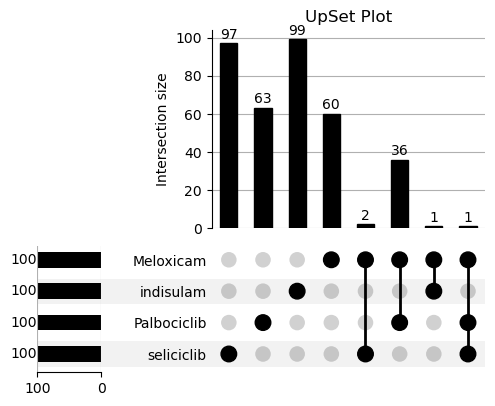

In [31]:
upset_dict = {}
for name in drug_dict.keys():
    if embed_method == 'resimnet':
        upset_dict[f"{name}"] = list(globals()[f'{name}_result_df']['drug2_name'])
    else:
        upset_dict[f"{name}"] = list(globals()[f'{name}_result_df']['compound_name'])

if input_mode == "multiple":
    upsetplot = from_contents(upset_dict)
    
    UpSet(upsetplot, subset_size='count', show_counts=True).plot()
    plt.title('UpSet Plot')
    plt.savefig('Upset_plot.png')
    display(HTML(f'<a href="./Upset_plot.png" download>Download: UpSet Plot</a>'))
    print("You can see if there are overlapping compounds in the results of each query compound.")

### Heatmap

In [34]:
if input_mode == "multiple":
    if embed_method == 'resimnet':
        df = pd.read_csv(query_filename, sep="\t", header=None)
        df.columns = ["drug2_name", "drug2_smiles"]
    
        for name, smiles in drug_dict.items():
            globals()[f'input_{name}_df'] = df
            globals()[f'input_{name}_df']['drug1_name'] = name
            globals()[f'input_{name}_df']['drug1_smiles'] = smiles
            
            input_filename = f"./input_heatmap_{name}.tsv"
            output_filename = f"./output_heatmap_{name}.tsv"
            globals()[f'input_{name}_df'].to_csv(input_filename, index=None, sep="\t")
            
            !python $sys_path/models/ReSimNet/main.py --save-prediction-new-pairs True --new-drug-pair-filename $input_filename --output-filename $output_filename --checkpoint-dir $sys_path/models/ReSimNet/results/ --data-path $sys_path/models/ReSimNet/tasks/data/drug\(v0.6\).pkl
            
    else:
        drug_names = list(embed_dict.keys())
        if sim_method == 'cosine':
            vectors = np.array(list(embed_dict.values()))
            vectors = vectors.squeeze()
            cosine_similarity_matrix = utils.calculate_cosine_similarity(vectors)
            df = pd.DataFrame(cosine_similarity_matrix, index=drug_names, columns=drug_names)
            
        elif sim_method == 'euclidean':
            num_drugs = len(drug_names)
            df = np.zeros((num_drugs, num_drugs))
            for i in range(num_drugs):
                for j in range(num_drugs):
                    if i != j:
                        df[i, j] = utils.euclidean_distance(embed_dict[drug_names[i]], embed_dict[drug_names[j]])
            
        sns.set(font_scale=1.0)
        plt.figure(figsize=(6, 6))
        sns.heatmap(df, cmap="OrRd", annot=True, fmt=".2f", cbar_kws={'label': f'{sim_method}'})
        plt.title(f"{embed_method}_{sim_method} similarity")
        plt.savefig(f'{embed_method}_{sim_method}.png')
        plt.show()
        display(HTML(f'<a href="./{embed_method}_{sim_method}.png" download>Download: {embed_method}_{sim_method} similarity</a>'))

/home/songhyeon/anaconda3/envs/Embdd/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/songhyeon/anaconda3/envs/Embdd/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
data_avg = []
data_jac = []
if input_mode == 'multiple' and embed_method == 'resimnet':
    for name in drug_dict.keys():
        output_filename = f'./output_heatmap_{name}.tsv'
        
        globals()[f'{name}_result_hp'] = pd.read_csv(output_filename, sep="\t")
        globals()[f'{name}_result_hp']['drug2_smiles'] = globals()[f'{name}_result_hp'].apply(lambda x: utils.make_clickable(x['drug2_smiles']), axis=1)
        globals()[f'{name}_result_hp']["ReSimNet_avg"] = globals()[f'{name}_result_hp'][[x for x in globals()[f'{name}_result_hp'].columns if x.startswith("ReSimNet")]].mean(axis=1)
        globals()[f'{name}_result_hp_avg'] = globals()[f'{name}_result_hp'][['drug1_name','drug2_name','ReSimNet_avg']]
        globals()[f'{name}_result_hp_jac'] = globals()[f'{name}_result_hp'][['drug1_name','drug2_name','jaccard_similarity']]
        globals()[f'{name}_result_hp_avg_pv'] = globals()[f'{name}_result_hp_avg'].pivot(index='drug1_name', columns='drug2_name', values='ReSimNet_avg')
        globals()[f'{name}_result_hp_jac_pv'] = globals()[f'{name}_result_hp_jac'].pivot(index='drug1_name', columns='drug2_name', values='jaccard_similarity')
        
        data_avg.append(globals()[f'{name}_result_hp_avg_pv'])
        data_jac.append(globals()[f'{name}_result_hp_jac_pv'])
        heatmap_avg = pd.concat(data_avg, axis=0)
        heatmap_avg = heatmap_avg.sort_index(axis=0).sort_index(axis=1)
        heatmap_jac = pd.concat(data_jac, axis=0)
        heatmap_jac = heatmap_jac.sort_index(axis=0).sort_index(axis=1)

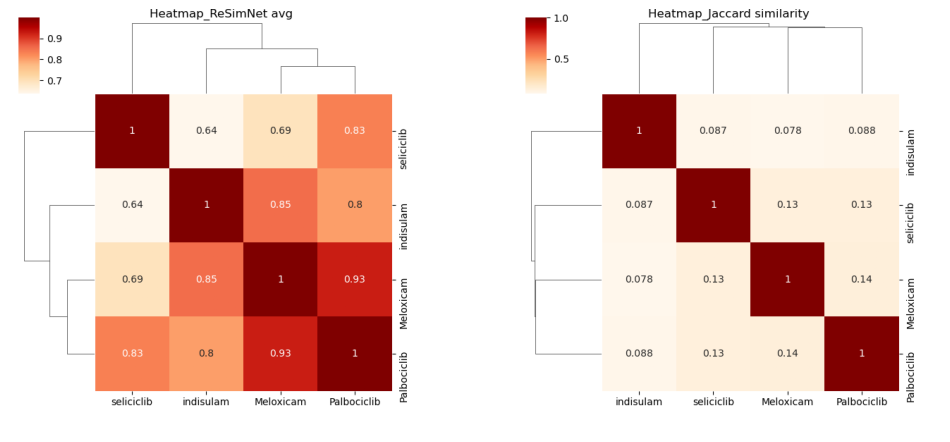

In [50]:
if input_mode == 'multiple' and embed_method == 'resimnet':
    resavg = sns.clustermap(heatmap_avg, annot=True, cmap='OrRd', figsize=(6,6))
    resavg.ax_heatmap.set_xlabel('')
    resavg.ax_heatmap.set_ylabel('')
    resavg.fig.suptitle('Heatmap_ReSimNet avg', y=1, x=0.5);
    resavg_filename = 'heatmap_resimnet_avg.png'
    plt.savefig(resavg_filename)
    plt.close()

    resjac = sns.clustermap(heatmap_jac, annot=True, cmap='OrRd', figsize=(6,6))
    resjac.ax_heatmap.set_xlabel('')
    resjac.ax_heatmap.set_ylabel('')
    resjac.fig.suptitle('Heatmap_Jaccard similarity', y=1, x=0.5);
    resjac_filename = 'heatmap_jaccard_similarity.png'
    plt.savefig(resjac_filename)
    plt.close()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(plt.imread(resavg_filename))
    axes[0].axis('off')

    axes[1].imshow(plt.imread(resjac_filename))
    axes[1].axis('off')

    plt.show()

    display(HTML(f'<a href="./heatmap_resimnet_avg.png" download>Download: Heatmap_ReSimNet avg</a>'))
    display(HTML(f'<a href="./heatmap_jaccard_similarity.png" download>Download: Heatmap_Jaccard similarity</a>'))

### Drug Enrichr

In [ ]:
for drug, candidates in upset_dict.items():
    def drug_enrichr_link(dataset, title = "Drug Enrichr Overall Results: {}"):
        url = f"https://maayanlab.cloud/DrugEnrichr/enrich?dataset={dataset}"
        html = "<a href=\"{}\" target='_blank'>{}</a>".format(url, title.format(drug))
        return HTML(html)

    ENRICHR_URL = 'http://amp.pharm.mssm.edu/DrugEnrichr/addList'
    drugs_str = '\n'.join(candidates)
    description = f'{drug} candidates'
    payload = {
        'list': (None, drugs_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing drug list')

    data = json.loads(response.text)

    ENRICHR_URL = 'http://amp.pharm.mssm.edu/DrugEnrichr/view?userListId=%s'
    user_list_id = data['userListId']
    dataset = data['shortId']
    response = requests.get(ENRICHR_URL % user_list_id)
    if not response.ok:
        raise Exception('Error getting drug list')
        
    data = json.loads(response.text)
    
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/DrugEnrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    drug_set_library = 'Drug_Repurposing_Hub_Mechanism_of_Action'
    response = requests.get(
        ENRICHR_URL + query_string % (user_list_id, drug_set_library)
    )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    data = json.loads(response.text)
    moa = [item[1] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]
    p_value = [item[2] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]
    z_score = [item[3] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]
    comb_score = [item[4] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]

    df = pd.DataFrame({'moa': moa, 'p-value': p_value, 'z-score': z_score, 'combined score': comb_score})
    styles = [dict(selector="caption", props=[("text-align", "left")])]
    df = df.style.set_caption(f"Table. Drug Enrichr MoA results of {drug}").set_table_styles(styles)
    display(df)
    display(drug_enrichr_link(dataset))